# Visualize Texas vaccination efforts

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## Specify region (county name or 'Statewide') and load data

In [2]:
county = "Statewide"

In [3]:
df = pd.read_csv("docs/vaccine/data.csv", index_col=['county', 'date'], parse_dates=['date'])
df = df.loc[county, :]

## Daily vaccine dose administration

Calculate daily changes in total doses administered

In [4]:
df_diff = pd.DataFrame(df['total_doses']).diff()
df_diff.iloc[0] = df['total_doses'][0] # Replace NaN value on first day with first total value
df_diff.rename(columns={"total_doses": "daily_doses"}, inplace=True)

Calculate 7-day simple moving average

In [5]:
window = 7
df_diff['daily_doses_avg'] = df_diff.rolling(window=window, min_periods=1).mean()

Calculate 14-day trendline

In [6]:
n = 14
x = np.arange(0,n)
coef = np.polyfit(x, df_diff['daily_doses'][-n:], 1)
poly1d_fnc = np.poly1d(coef)

Plot

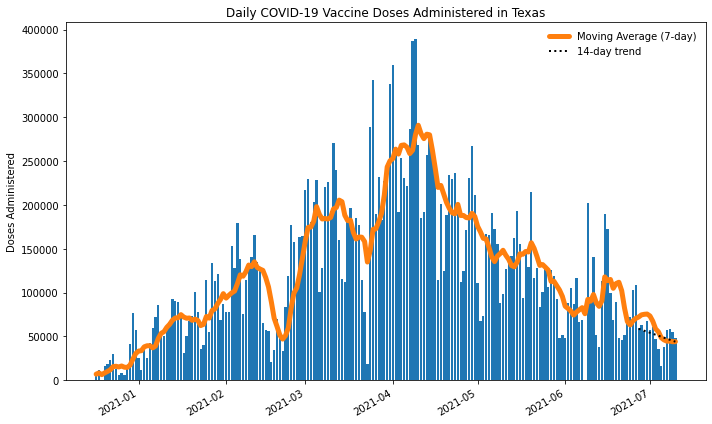

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(df_diff.index[:-1], df_diff['daily_doses'][1:])
plt.plot(df_diff.index[:-1], df_diff['daily_doses_avg'][1:], color="C1", linewidth=5, 
         solid_capstyle="round", label=f"Moving Average ({window}-day)")
plt.plot(df_diff.index[-n-1:-1], poly1d_fnc(x), ':k', linewidth=2, label=f"{n}-day trend")
fig.autofmt_xdate()
plt.ylabel("Doses Administered")
if county == "Statewide":
    plt.title("Daily COVID-19 Vaccine Doses Administered in Texas")
else:
    plt.title(f"Daily COVID-19 Vaccine Doses Administered in {county} County")
plt.legend(frameon=False)
plt.tight_layout()
# plt.savefig(f"DailyDoses_{county}.png", dpi=300, facecolor="w", transparent=False)

In [8]:
dose_rate = df_diff['daily_doses_avg'][-1]
print(f"The dose administration rate over the last week was {dose_rate:0,.0f} doses per day.\n" +
      f"At this rate, it will take about {1e6/dose_rate:0.1f} days to administer the next one million doses.")

The dose administration rate over the last week was 44,144 doses per day.
At this rate, it will take about 22.7 days to administer the next one million doses.


## Weekly vaccine dose administration

Resample data to calculate weekly changes in total doses administered

In [9]:
df_weekly = pd.DataFrame(df['total_doses']).resample('W', label='left', closed='right').last()
df_weekly_diff = df_weekly.diff()
df_weekly_diff.iloc[0] = df_weekly['total_doses'][0] # Replace NaN value on first week with first total value
df_weekly_diff.rename(columns={"total_doses": "weekly_doses"}, inplace=True)

Plot

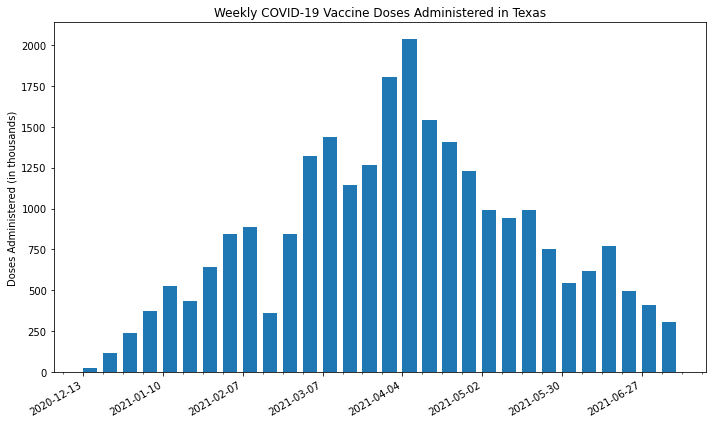

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(df_weekly_diff.index, df_weekly_diff['weekly_doses'], width=5, align='edge')
plt.xticks(df_weekly_diff.index[::4])
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
fig.autofmt_xdate()
if county == "Statewide":
    plt.title("Weekly COVID-19 Vaccine Doses Administered in Texas")
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1e3))
    ax.yaxis.set_major_formatter(ticks_y)
    plt.ylabel("Doses Administered (in thousands)")
else:
    plt.title(f"Weekly COVID-19 Vaccine Doses Administered in {county} County")
    plt.ylabel("Doses Administered")
plt.tight_layout()
# plt.savefig(f"WeeklyDoses_{county}.png", dpi=300, facecolor="w", transparent=False)

## Daily number of people receiving first dose

Load cumulative data and calculate daily changes number of people with at least one dose

In [11]:
df_diff = pd.DataFrame(df['one_dose']).diff()
df_diff.iloc[0] = df['one_dose'][0] # Replace NaN value on first day with first total value

Calculate 7-day simple moving average

In [12]:
window = 7
df_diff['one_dose_avg'] = df_diff.rolling(window=window, min_periods=1).mean()

Calculate 14-day trendline

In [13]:
n = 14
x = np.arange(0,n)
coef = np.polyfit(x, df_diff['one_dose'][-n:], 1)
poly1d_fnc = np.poly1d(coef)

Plot

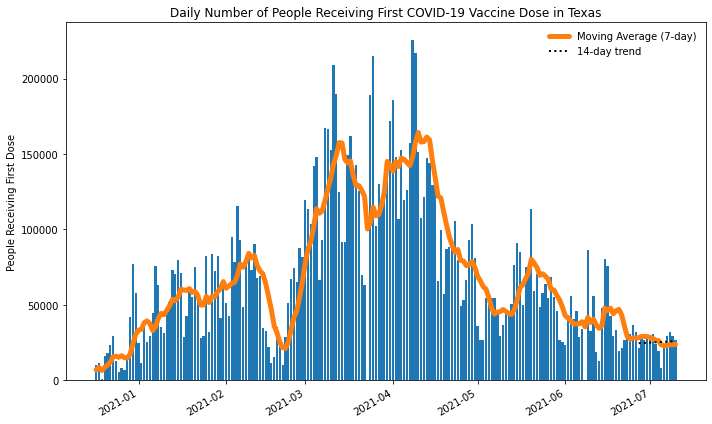

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(df_diff.index[:-1], df_diff['one_dose'][1:])
plt.plot(df_diff.index[:-1], df_diff['one_dose_avg'][1:], color="C1", linewidth=5, 
         solid_capstyle="round", label=f"Moving Average ({window}-day)")
plt.plot(df_diff.index[-n-1:-1], poly1d_fnc(x), ':k', linewidth=2, label=f"{n}-day trend")
ax.set_ylim(bottom=0)
fig.autofmt_xdate()
plt.ylabel("People Receiving First Dose")
if county == "Statewide":
    plt.title("Daily Number of People Receiving First COVID-19 Vaccine Dose in Texas")
else:
    plt.title(f"Daily Number of People Receiving First COVID-19 Vaccine Doses in {county} County")
plt.legend(frameon=False)
plt.tight_layout()
# plt.savefig(f"DailyFirstDose_{county}.png", dpi=300, facecolor="w", transparent=False)

In [15]:
dose_rate = df_diff['one_dose_avg'][-1]
print(f"The first dose vaccination rate over the last week was {dose_rate:0,.0f} people per day.\n" +
      f"At this rate, it will take about {1e6/dose_rate:0.1f} days to administer first doses to the next one million people.")

The first dose vaccination rate over the last week was 23,933 people per day.
At this rate, it will take about 41.8 days to administer first doses to the next one million people.


## Weekly number of people receiving first dose

Resample data to calculate weekly changes in number of people receiving fist dose

In [16]:
df_weekly = pd.DataFrame(df['one_dose']).resample('W', label='left', closed='right').last()
df_weekly_diff = df_weekly.diff()
df_weekly_diff.iloc[0] = df_weekly['one_dose'][0] # Replace NaN value on first week with first total value

Plot

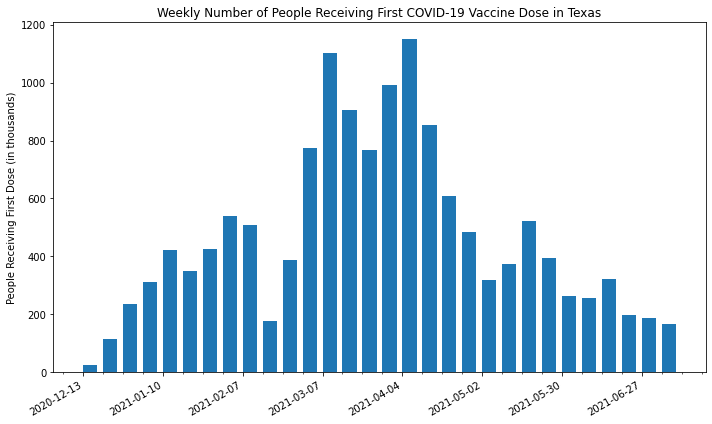

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(df_weekly_diff.index, df_weekly_diff['one_dose'], width=5, align='edge')
plt.xticks(df_weekly_diff.index[::4])
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
fig.autofmt_xdate()
if county == "Statewide":
    plt.title("Weekly Number of People Receiving First COVID-19 Vaccine Dose in Texas")
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1e3))
    ax.yaxis.set_major_formatter(ticks_y)
    plt.ylabel("People Receiving First Dose (in thousands)")
else:
    plt.title(f"Weekly Number of People Receiving First COVID-19 Vaccine Doses in {county} County")
    plt.ylabel("People Receiving First Dose")
plt.tight_layout()
# plt.savefig(f"WeeklyFirstDose_{county}.png", dpi=300, facecolor="w", transparent=False)

## Estimate Janssen (Johnson & Johnson) Vaccine Use

Load data and calculate discrepancy between number of people vaccinated, number of
people with at least one dose, and total number of doses administered to estimate the
number of people that have received Janssen vaccine

In [18]:
df['pfizer_moderna_first'] = df['total_doses'] - df['vaccinated']
df['pfizer_moderna_second'] = df['total_doses'] - df['one_dose']
df['janssen'] = df['one_dose'] + df['vaccinated'] - df['total_doses']
df.loc[df.index < "2021-03-01", "janssen"] = 0 # Zero all values prior to the first Janssen vaccine distribution

Plot

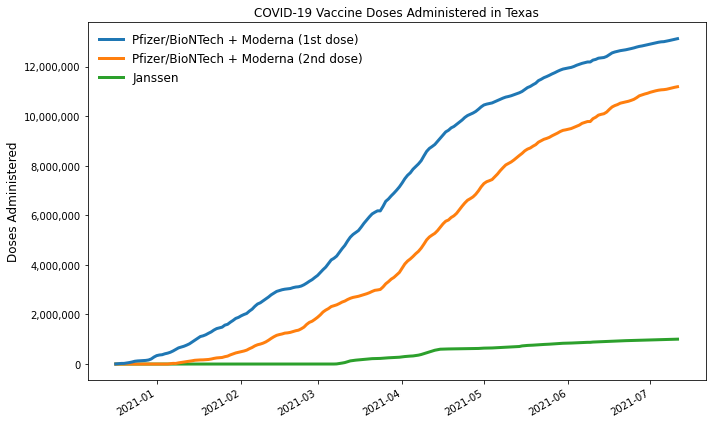

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(df.index, df['pfizer_moderna_first'], linewidth=3, label="Pfizer/BioNTech + Moderna (1st dose)", zorder=3)
plt.plot(df.index, df['pfizer_moderna_second'], linewidth=3, label="Pfizer/BioNTech + Moderna (2nd dose)", zorder=2)
plt.plot(df.index, df['janssen'], linewidth=3, label="Janssen", zorder=1)
fig.autofmt_xdate()
plt.ylabel("Doses Administered", fontsize=12)
ax.yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
if county == "Statewide":
    plt.title("COVID-19 Vaccine Doses Administered in Texas")
else:
    plt.title(f"COVID-19 Vaccine Doses Administered in {county} County")
plt.legend(frameon=False, fontsize=12)
plt.tight_layout()
# plt.savefig(f"DoseKind_{county}.png", dpi=300, facecolor="w", transparent=False)

In [20]:
pct_janssen = df.iloc[-1]['janssen'] / df.iloc[-1]['vaccinated']
print(f"People vaccinated with Janssen ({df.iloc[-1]['janssen']:0,.0f}) currently account for " +
      f"{pct_janssen:0.2%} of all complete vaccinations ({df.iloc[-1]['vaccinated']:0,.0f})")

People vaccinated with Janssen (1,004,094) currently account for 8.24% of all complete vaccinations (12,192,795)
